Dans un second temps, passons maintenant à un modèle ayant recours à des réseaux de neurones pour voir si ce dernier est plus efficace pour prédire le cours des actions d'Apple

0 - Préparatifs généraux

Beaucoup de préparatifs vont être les mêmes que dans le modèle du moving average

In [ ]:
# Importation des biblothèques 

import yfinance as yf
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# On utilise directement pandas
df=pd.read_csv("AAPL.csv")
# On met les dates dans le bon format
df['Date']=pd.to_datetime(df['Date'])
df = df[df['Date'] >= pd.to_datetime('2020-01-01')]
df=df[['Date', 'Close']]

In [ ]:
# Rappel de la courbe
plt.plot(df['Date'], df['Close'])

I - Modélisation LSTM

I - 1 : Préparation pour faire fonctionner le modèle

Le but du modèle choisi, modèle LSTM (Long short-term memory) est de garder quelques valeurs précedentes en mémoire pour prédire la prochaine valeur avec une manière de prédire plus complexe qu'une relation linéaire ou de moyenne.

On commence alors par créer une fonction qui va nous renvoyer notre dataframe avec des colonnes ajoutées : à savoir les valeurs de 'Close' aux 4 jours qui suivent notre date. La quatrième valeur est appelée "Target". Target est ainsi la valeur à T+4 de 'Close'

In [ ]:
# On commence par définir nos décalages qui vont nous permettre de prendre les valeurs du futur 
shifts=[-1, -2, -3, -4]

In [ ]:

def add_shifted_columns(df, shifts):
  
  for index, Target in enumerate(shifts): # On conserve l'index car il nous servira
                                             # On boucle sur toutes les valeurs pour ajouter toutes les colonnes

    df_temp=df['Close'].shift(Target) # Utilisation de la fonction shift de panda : 
                                         # df.['Close].shift[-1] renvoie la valeur suivante de Close (par rapport au temps dans la boucle)
    if index<(len(shifts)-1):
      col_name=f'Target - {index+1}' # On crée le nom de colonne Target - n (on réequilibre l'index qui commençait à 0)

    else:
      col_name='Target' # Si on est au bout de la liste de décalages, alors on a atteint notre target

    df[col_name]=df_temp # On ajoute la colonne avec son nouveau nom à notre tableau final à l'aide de notre tableau temporaire

    df['Target Date']=df['Date'].shift(-len(shifts)) # On ajoute la date associée au Target final

  return df


In [ ]:
# Testons le résultat

df = add_shifted_columns(df,shifts)
df

In [ ]:
# On replace Target Date au sein du tableau pour plus d'esthétique
ordre_colonnes = ['Date', 'Close', 'Target Date', 'Target - 1', 'Target - 2', 'Target - 3', 'Target']
df = df[ordre_colonnes]

On rappelle que l'existence de trous entre les dates est liée à la fermeture des marchés pendant les week-ends.

On entre plus en profondeur dans la modélisation, ainsi la date originale et la valeur originale de Close ne nous intéressent plus, il vient :

In [ ]:
df=df.drop(['Date', 'Close'],axis=1) 

Par la suite, il faut aussi transformer le format de nos paramètres pour qu'ils conviennent à l'utilisation d'un modèle LSTM.
On crée une fonction qui va diviser en 3 catégories nos variables, (Date, Targets - n, Target) et les mettre au bon format.

Il s'agit d'adapter la forme des caractéristiques à une forme qui convient à l'entrée d'un modèle LSTM.

In [ ]:
def formatage(df):

    # On commence par les dates 
    dates = df.iloc[:, 0].values

    # Puis les Targets intermédiaires 
    X = df.iloc[:, 1:-1].values.reshape(-1, df.shape[1] - 2, 1).astype(np.float32)

    # -1 : réorganiser les données tout en conservant le même nombre total d'éléments (convention)

    # df.shape[1] - 2 : la nouvelle taille de la deuxième dimension (nombre de colonnes)
                       # Donc ici on garde le nombre de Target intermédiaire en retirant Date et Target Final

    # 1 : Taille de la troisème dimension : représentation d'une série temporelle univariée

    # Et enfin on met le Target au bon format
    Y = df.iloc[:, -1].values.astype(np.float32)

    # De nombreux modèles préfèrent travailler avec des données en virgule flottante 32 bits 
    # plutôt qu'avec des types de données plus larges.

    return dates, X, Y


In [ ]:
# On applique à notre data frame 

dates, X, Y = formatage(df) # X représente les Targets Intermédiaires, Y le Target Final

dates.shape, X.shape, Y.shape

Maintenant que nos trois variables, 'dates', 'X' et 'Y' sont au bon format, il y a un autre prérequis au bon fonctionnement d'un modèle LSTM.
Il s'agit de la définition des périodes d'entraînement du modèle, de validation puis de test.
Comme nos variables sont désormées "formatées", elles sont beaucoup plus faciles à utiliser.

In [ ]:
def train_val_test(dates, X, Y, train_ratio, val_ratio): # On connaît maintenant les formats des objets pour les découper

    train_index = int(len(dates) * train_ratio) # Nombre de dates sur lesquelles on va s'entraîner
    val_index = train_index + int(len(dates) * val_ratio) # Nombre de dates sur lesquelles on s'entraîne et on valide

    dates_train, X_train, Y_train = dates[:train_index], X[:train_index], Y[:train_index] # Période d'entraînement

    dates_val, X_val, Y_val = dates[train_index:val_index], X[train_index:val_index], Y[train_index: val_index] # Période de validation
    # (qui justifie la définition de val_index)

    dates_test, X_test, Y_test = dates[val_index:], X[val_index:], Y[ val_index:] # Période de test

    return (dates_train, X_train, Y_train), (dates_val, X_val, Y_val), (dates_test, X_test, Y_test)


In [ ]:
# On applique à nos dates 

(dates_train, X_train, Y_train), (dates_val, X_val, Y_val), (dates_test, X_test, Y_test) = train_val_test(dates, X, Y, 0.8,0.1)

# On définit 80% d'entrainement, 10% de validation et 10% de test pour notre modèle

Visualisons alors sur notre courbe originale les périodes d'entraînement, de validation et de test du modèle.

In [ ]:
plt.plot(dates_train, Y_train)
plt.plot(dates_val, Y_val)
plt.plot(dates_test, Y_test)

plt.legend(['Train', 'Validation', 'Test']) # Il s'agit en fait de trois courbes 

I - 2 : Implémentation du modèle

Il est alors l'heure d'expliciter le modèle maintenant que les préparatifs sont prêts. 
Il s'agit comme dit précedemment d'un modèle LSTM qui s'implémente sous la forme suivante :

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])


Maintenant, on entraîne le modèle sur l'intervalle qu'on lui a consacré pour son entraînement

In [31]:
model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100)

Epoch 1/100
25/25 [==============================] - 1s 8ms/step - loss: 17741.4453 - mean_absolute_error: 129.7715 - val_loss: 25878.4219 - val_mean_absolute_error: 160.4892
Epoch 2/100
25/25 [==============================] - 0s 2ms/step - loss: 16976.3867 - mean_absolute_error: 126.7619 - val_loss: 24373.0293 - val_mean_absolute_error: 155.7269
Epoch 3/100
25/25 [==============================] - 0s 1ms/step - loss: 15144.3652 - mean_absolute_error: 119.1387 - val_loss: 20880.7871 - val_mean_absolute_error: 144.0691
Epoch 4/100
25/25 [==============================] - 0s 1ms/step - loss: 10991.4746 - mean_absolute_error: 99.7023 - val_loss: 13223.2070 - val_mean_absolute_error: 114.4282
Epoch 5/100
25/25 [==============================] - 0s 1ms/step - loss: 5184.7358 - mean_absolute_error: 65.3357 - val_loss: 5884.4219 - val_mean_absolute_error: 75.8928
Epoch 6/100
25/25 [==============================] - 0s 1ms/step - loss: 1754.3627 - mean_absolute_error: 36.8306 - val_loss: 1960

Maintenant que notre modèle s'est entraîné, il est l'heure de voir si son entraînement a été efficace

I - 3 : Visualisation du modèle

25/25 [==============================] - 0s 510us/step


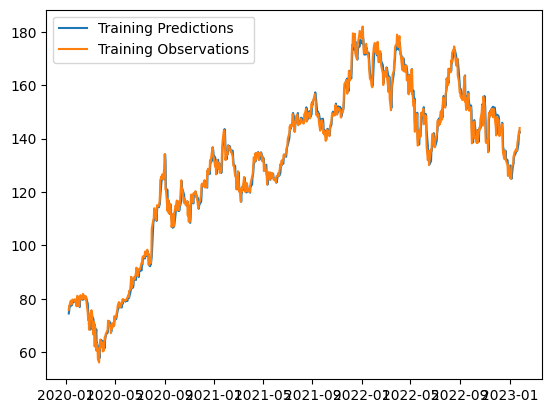

In [32]:
# Intervalle d'entraînement 

train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, Y_train)
plt.legend(['Training Predictions', 'Training Observations'])

3/3 [==============================] - 0s 2ms/step


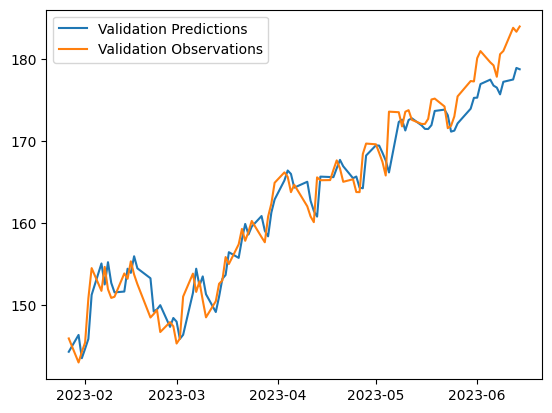

In [34]:
# De même avec la période de validation 

val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, Y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

4/4 [==============================] - 0s 2ms/step


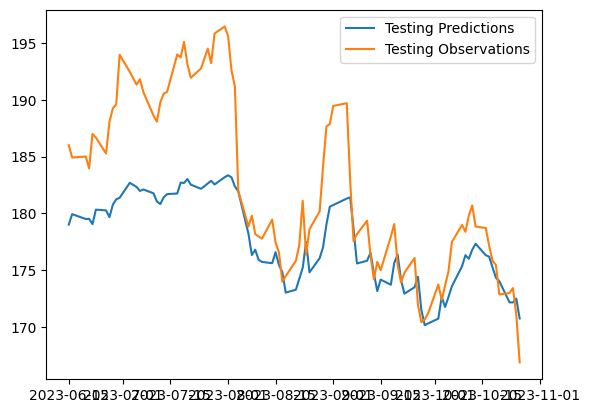

In [36]:
# Et enfin sur la partie de tests :

test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, Y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

On peut essayer de tout regrouper pour avoir une vue d'ensemble de notre modèle comparé à la réalité !

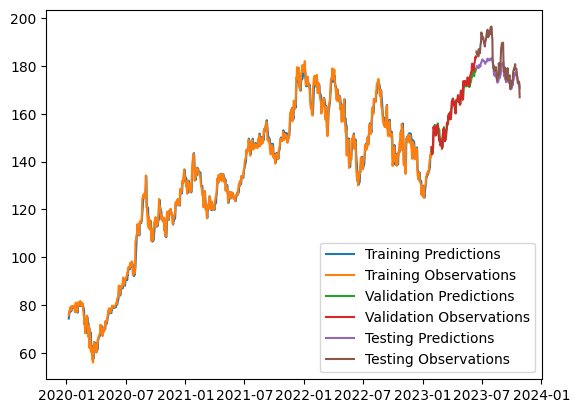

In [38]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, Y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, Y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, Y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

Cherchons maintenant les erreurs du modèle.

In [40]:
import tensorflow as tf

In [42]:
print(tf.keras.metrics.mean_absolute_error(train_predictions, Y_train).numpy())
print(tf.keras.metrics.mean_absolute_error(val_predictions, Y_val).numpy())


2.1060133
1.991233
nan


In [45]:
nan_indices_test_predictions = np.isnan(test_predictions)
print("Indices des valeurs nan dans test_predictions:", np.where(nan_indices_test_predictions)[0])

nan_indices_Y_test = np.isnan(Y_test)
print("Indices des valeurs nan dans Y_test:", np.where(nan_indices_Y_test)[0])

Indices des valeurs nan dans test_predictions: [94 95 96]
Indices des valeurs nan dans Y_test: [93 94 95 96]


In [47]:
print(tf.keras.metrics.mean_absolute_error(test_predictions[:93], Y_test[:93]).numpy())

4.970828


Conclusion sur l'efficacité du modèle :